# Exercice récapitulatif 1

## Enoncé

Soit le système à commander décrit par la fonction de transfert échantillonnée:

$$ G(z) = \frac{0.8 (z + 0.8)}{(z - 0.7) (z - 0.5)} $$

La période d'échantillonnage vaut $h=0.3\, \mathrm{s}$. Tracer $|G(e^{j\omega h})|$ dans un diagramme de Bode. Les spécifications requièrent une marge de phase d'environ $60^\circ$, aucun statisme d'asservissement et une bande passante en boucle fermée de $2\, \mathrm{rad/s}$. Dimensionner un régulateur numérique remplissant ces spécifications. *[Longchamp]*

***

## Solution

Le cahier des charges impose un statisme d'asservissement nul, soit un régulateur avec action intégrale.

La méthodologie de résolution sera donc d'essayer un simple régulateur PI, et, si la marge de phase est insuffisante, ajouter une action dérivée.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('../my_params.mplstyle')

import control

<IPython.core.display.Javascript object>


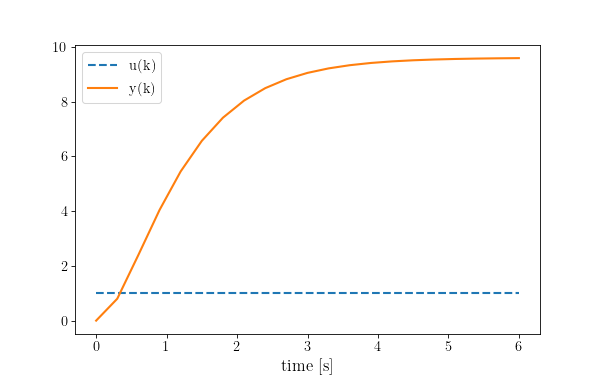

In [2]:
h = 0.3

Gz = 0.8 * control.tf([1, 0.8], [1, -1.2, 0.35], h)

u_s = [1 for _ in range(21)]
t_s, y_s, _ = control.forced_response(Gz, U=u_s)

fig, ax = plt.subplots()
ax.plot(t_s, u_s, '--', label='u(k)')
ax.plot(t_s, y_s, '-', label='y(k)')
ax.set_xlabel('time [s]')
_ = ax.legend()

<IPython.core.display.Javascript object>


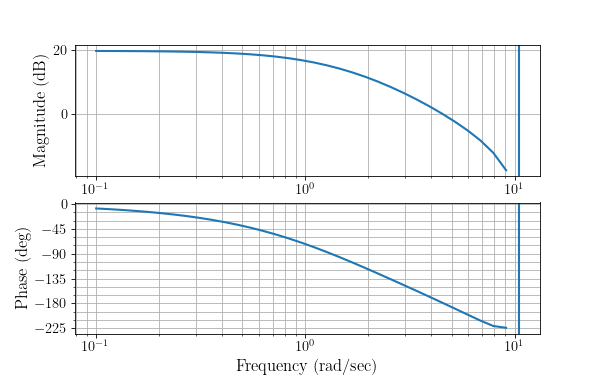

In [3]:
mag, phase, omega = control.bode_plot(Gz, dB=True)

<IPython.core.display.Javascript object>


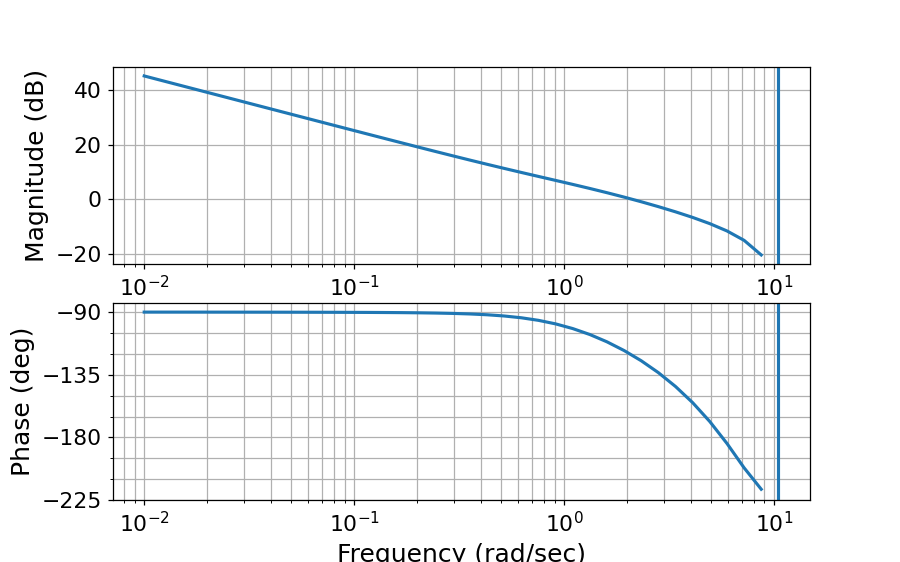

In [46]:
Kp = 10 ** (-14.5 / 20)

Ti = 1
zi = 1 / (1 + h / Ti)

Td = 0.25
zd = (Td / h) / (1 + Td / h)

K = Kp * (1 + Td / h) * control.tf([1, -zd], [1, 0], h) * (1 + h / Ti) * control.tf([1, -zi], [1, -1], h)

KG = K * Gz

_ = control.bode_plot(KG, dB=True)

Ce réglage a été obtenu de manière itérative en procédant de la sorte:

- ajout d'une intégrale avec $Ti = 1$ afin de redresser la courbe des gains pour les faibles pulsations
- ajout de $Kp$ afin que $\omega_x=2\, \mathrm{rad/s}$
- en vérifiant la marge de phase, nous obtenons environ $40^\circ$
- remise de $Kp$ à 1
- ajout d'une dérivée avec $Td = 0.5$ afin d'augmenter la phase; la marge de phase obtenue est trop grande
- diminution itérative de $Td$ jusqu'à obtenir une phase d'environ $120^\circ$ pour $\omega = 2\, \mathrm{rad/s}$
- calcul de $Kp$ afin que $\omega_x=2\, \mathrm{rad/s}$

<IPython.core.display.Javascript object>


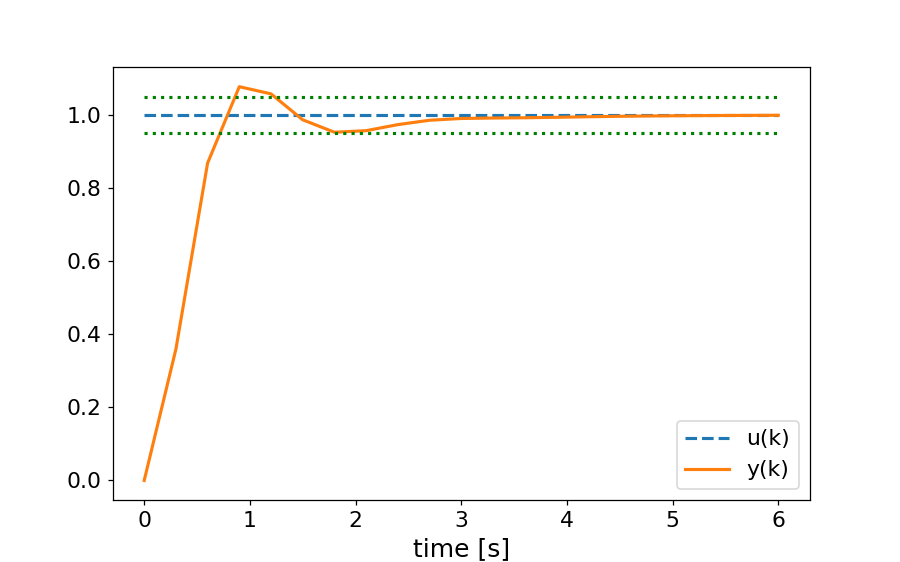

In [55]:
T = KG / (1 + KG)

u_s = [1 for _ in range(21)]
t_s, y_s, _ = control.forced_response(T, U=u_s)

l_max = [1.05 for _ in u_s]
l_min = [0.95 for _ in u_s]
fig, ax = plt.subplots()
ax.plot(t_s, u_s, '--', label='u(k)')
ax.plot(t_s, y_s, '-', label='y(k)')
ax.plot(t_s, l_max, 'g:')
ax.plot(t_s, l_min, 'g:')
ax.set_xlabel('time [s]')
_ = ax.legend()

La courbe obtenue n'est pas trop mauvaise:

- on atteint $63\, \%$ en environ $0.47\, \mathrm{s}$; ce qui correspond à une pulsation de coupure légèrement supérieure à $2\, \mathrm{rad/s}$ en boucle fermée 
- le système possède un dépassement de $7.6\, \%$; aucune précision n'est donnée quant au dépassement acceptable et cette valeur est relativement faible
- le système entre dans la zone à $\pm 5\, \%$ en $1\, \mathrm{s}$; en comparaison, un système d'ordre 1 aurait mis $3 \tau = 1.5\, \mathrm{s}$